### Notatki
- trzeba zamienić x i y (kolumny) miejscami,
- wynikowy obraz jest obrócony (przez odejmowanie?) i przerzucony w poziomie,
- dobrze jest przyciąć wg maski, żeby ograniczyć rozmiar,

In [1]:
import cv2
import numpy as np
from pyproj import Proj, transform
import json
import os
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
def convert_coords(x, y, proj_src="EPSG:2180", proj_dst="EPSG:4326"):
    proj_src = Proj(proj_src)
    proj_dst = Proj(proj_dst)

    lon, lat = transform(proj_src, proj_dst, x, y)

    return lon, lat

### Load points

In [3]:
path = r"C:\Users\gtraw\OneDrive\Pulpit\UM sem. 2\ProjektBadawczy\apps\image_processing\images"
data_weti1 = {}
data_weti2 = {}
for i, filename in enumerate(os.listdir(path)):
        f = os.path.join(path, filename)
        if os.path.isfile(f) and filename.endswith(".json"):
                with open(f) as json_file:
                        json_data = json.load(json_file)
                for obj in json_data['objects']:
                        id_data, point_data = obj['tags'].split(';')
                        _, name = id_data.split()
                        x, y = point_data.replace(point_data.split()[0], '').split(',')
                        if 'weti1' in filename:
                                data_weti1[name] = {
                                        'geo_coords': [float(y.strip()), float(x.strip())], #[float(x.strip()), float(y.strip())],
                                        'img_coords': obj['points']
                                }
                        elif 'weti2' in filename:
                                data_weti2[name] = {
                                        'geo_coords': [float(y.strip()), float(x.strip())], #[float(x.strip()), float(y.strip())],
                                        'img_coords': obj['points']
                                }


### Load and preprocess images

In [4]:
def crop_img_with_mask(image, mask):
    alpha_channel = mask[:, :, 3]

    rows, cols = alpha_channel.shape
    first_row, last_row = 0, rows - 1
    first_col, last_col = 0, cols - 1

    for i in range(rows):
        if np.any(alpha_channel[i, :] == 0):
            first_row = i
            break

    for i in range(rows - 1, -1, -1):
        if np.any(alpha_channel[i, :] == 0):
            last_row = i
            break

    for j in range(cols):
        if np.any(alpha_channel[:, j] == 0):
            first_col = j
            break

    for j in range(cols - 1, -1, -1):
        if np.any(alpha_channel[:, j] == 0):
            last_col = j
            break

    cropped_image = image[first_row:last_row+1, first_col:last_col+1]
    return cropped_image, (first_col, first_row, last_col, last_row)

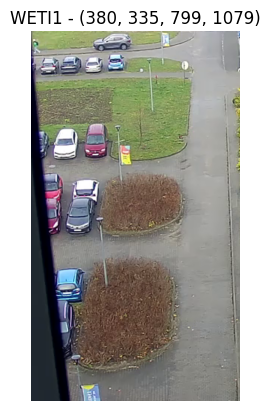

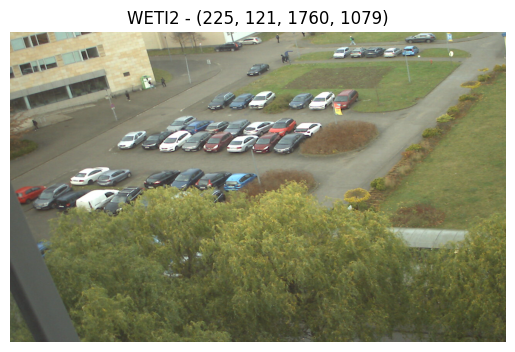

In [5]:
image_weti1 = cv2.cvtColor(cv2.imread(r"C:\Users\gtraw\OneDrive\Pulpit\UM sem. 2\ProjektBadawczy\apps\image_processing\images\surf1.jpg"), cv2.COLOR_RGB2BGR)
image_weti2 = cv2.cvtColor(cv2.imread(r"C:\Users\gtraw\OneDrive\Pulpit\UM sem. 2\ProjektBadawczy\apps\image_processing\images\surf2.jpg"), cv2.COLOR_RGB2BGR)

mask_weti1 = np.array(Image.open(r"C:\Users\gtraw\OneDrive\Pulpit\UM sem. 2\ProjektBadawczy\apps\image_processing\images\weti1_mask.jpg").convert("RGBA"))
mask_weti2 = np.array(Image.open(r"C:\Users\gtraw\OneDrive\Pulpit\UM sem. 2\ProjektBadawczy\apps\image_processing\images\weti2_mask.jpg").convert("RGBA"))

image_c_weti1, bbox_weti1 = crop_img_with_mask(image_weti1, mask_weti1)
image_c_weti2, bbox_weti2 = crop_img_with_mask(image_weti2, mask_weti2)

plt.imshow(image_c_weti1)
plt.title(f"WETI1 - {bbox_weti1}")
plt.axis("off")
plt.show()
plt.imshow(image_c_weti2)
plt.title(f"WETI2 - {bbox_weti2}")
plt.axis("off")
plt.show()

### Preprocess points

In [8]:
keys_weti1 = data_weti1.keys()
geo_points_weti1 = np.array([data_weti1[k]['geo_coords'] for k in keys_weti1])
img_points_weti1 = np.array([data_weti1[k]['img_coords'] - np.array(bbox_weti1[:2]) for k in keys_weti1])

keys_weti2 = data_weti2.keys()
geo_points_weti2 = np.array([data_weti2[k]['geo_coords'] for k in keys_weti2])
img_points_weti2 = np.array([data_weti2[k]['img_coords'] - np.array(bbox_weti2[:2]) for k in keys_weti2])

minx = min(geo_points_weti1[:, 0].min(), geo_points_weti2[:, 0].min())
miny = min(geo_points_weti1[:, 1].min(), geo_points_weti2[:, 1].min())

geo_points_weti1[:, 0] -= minx
geo_points_weti1[:, 1] -= miny
geo_points_weti2[:, 0] -= minx
geo_points_weti2[:, 1] -= miny

In [50]:
# print(img_points_weti1,'\n----------------------------------')

# print(geo_points_weti1,'\n----------------------------------')

# Offset EPSG:2180 points to start at (0, 0) by subtracting minimums
geo_points_weti1[:, 0] -= geo_points_weti1[:, 0].min()
geo_points_weti1[:, 1] -= geo_points_weti1[:, 1].min()

# print(geo_points_weti1,'\n----------------------------------')

# tmp = geo_points_weti1[:, 0]
# geo_points_weti1[:, 0] = geo_points_weti1[:, 1]
# geo_points_weti1[:, 1] = tmp

# Scale geo points to match image dimensions for homography calculation
scale_x = image_weti1.shape[1] / geo_points_weti1[:, 0].max()
scale_y = image_weti1.shape[0] / geo_points_weti1[:, 1].max()

geo_points_weti1[:, 0] *= scale_x
geo_points_weti1[:, 1] *= scale_y

# print(geo_points_weti1)

# # Compute the homography matrix
# homography_matrix_weti1, status_weti1 = cv2.findHomography(img_points_weti1, geo_points_weti1)

# # Warp the image using the computed homography
# img1_warp = cv2.warpPerspective(image_weti1, homography_matrix_weti1, (image_weti1.shape[1], image_weti1.shape[0]))

# # Display the transformed image
# plt.imshow(img1_warp)
# plt.show()


# Homography

In [9]:
def make_image_top_down(image, geo_points_og, img_points_og, aa=False, figsize=None, draw_points=None):
    geo_points = geo_points_og.copy()
    img_points = img_points_og.copy()

    if aa:
        scale_x = image.shape[1] / geo_points[:, 0].max()
        scale_y = image.shape[0] / geo_points[:, 1].max()

        geo_points[:, 0] *= max(scale_x, scale_y)
        geo_points[:, 1] *= max(scale_x, scale_y)

    homography_matrix, _ = cv2.findHomography(img_points, geo_points)

    height, width = image.shape[:2]

    image_corners = np.array([
        [0, 0],              
        [width, 0],          
        [width, height],     
        [0, height]          
    ], dtype="float32")

    transformed_corners = cv2.perspectiveTransform(image_corners.reshape(-1, 1, 2), homography_matrix).reshape(-1, 2)

    x_min, y_min = transformed_corners.min(axis=0)
    x_max, y_max = transformed_corners.max(axis=0)

    output_width = int(x_max - x_min)
    output_height = int(y_max - y_min)

    translation_matrix = np.array([
        [1, 0, -x_min],
        [0, 1, -y_min],
        [0, 0, 1]
    ])

    adjusted_homography = np.dot(translation_matrix, homography_matrix)

    img1_warp_full = cv2.warpPerspective(image, adjusted_homography, (output_width, output_height))

    if figsize is not None:
        print(f"{figsize=}")
        plt.figure(figsize=figsize)
    plt.imshow(cv2.flip(cv2.rotate(img1_warp_full, cv2.ROTATE_180), 1))
    plt.show()

    return adjusted_homography

### Saving info

In [25]:
info_path = r"C:\Users\gtraw\OneDrive\Pulpit\UM sem. 2\ProjektBadawczy\apps\image_processing\homography_info"

H1, status1 = cv2.findHomography(img_points_weti1, geo_points_weti1)
H2, status2 = cv2.findHomography(img_points_weti2, geo_points_weti2)

homography_info = {
    'cameras': 
    {
        'weti1':
        {
            'offset': bbox_weti1[:2],
            'filename': 'H_weti1.npy'
        },

        'weti2':
        {
            'offset': bbox_weti2[:2],
            'filename': 'H_weti2.npy'
        }
    }
}

np.save(os.path.join(info_path, homography_info['cameras']['weti1']['filename']), H1)
np.save(os.path.join(info_path, homography_info['cameras']['weti2']['filename']), H2)

with open(os.path.join(info_path, 'info'), 'w') as json_file:
    json.dump(homography_info, json_file, indent=4)

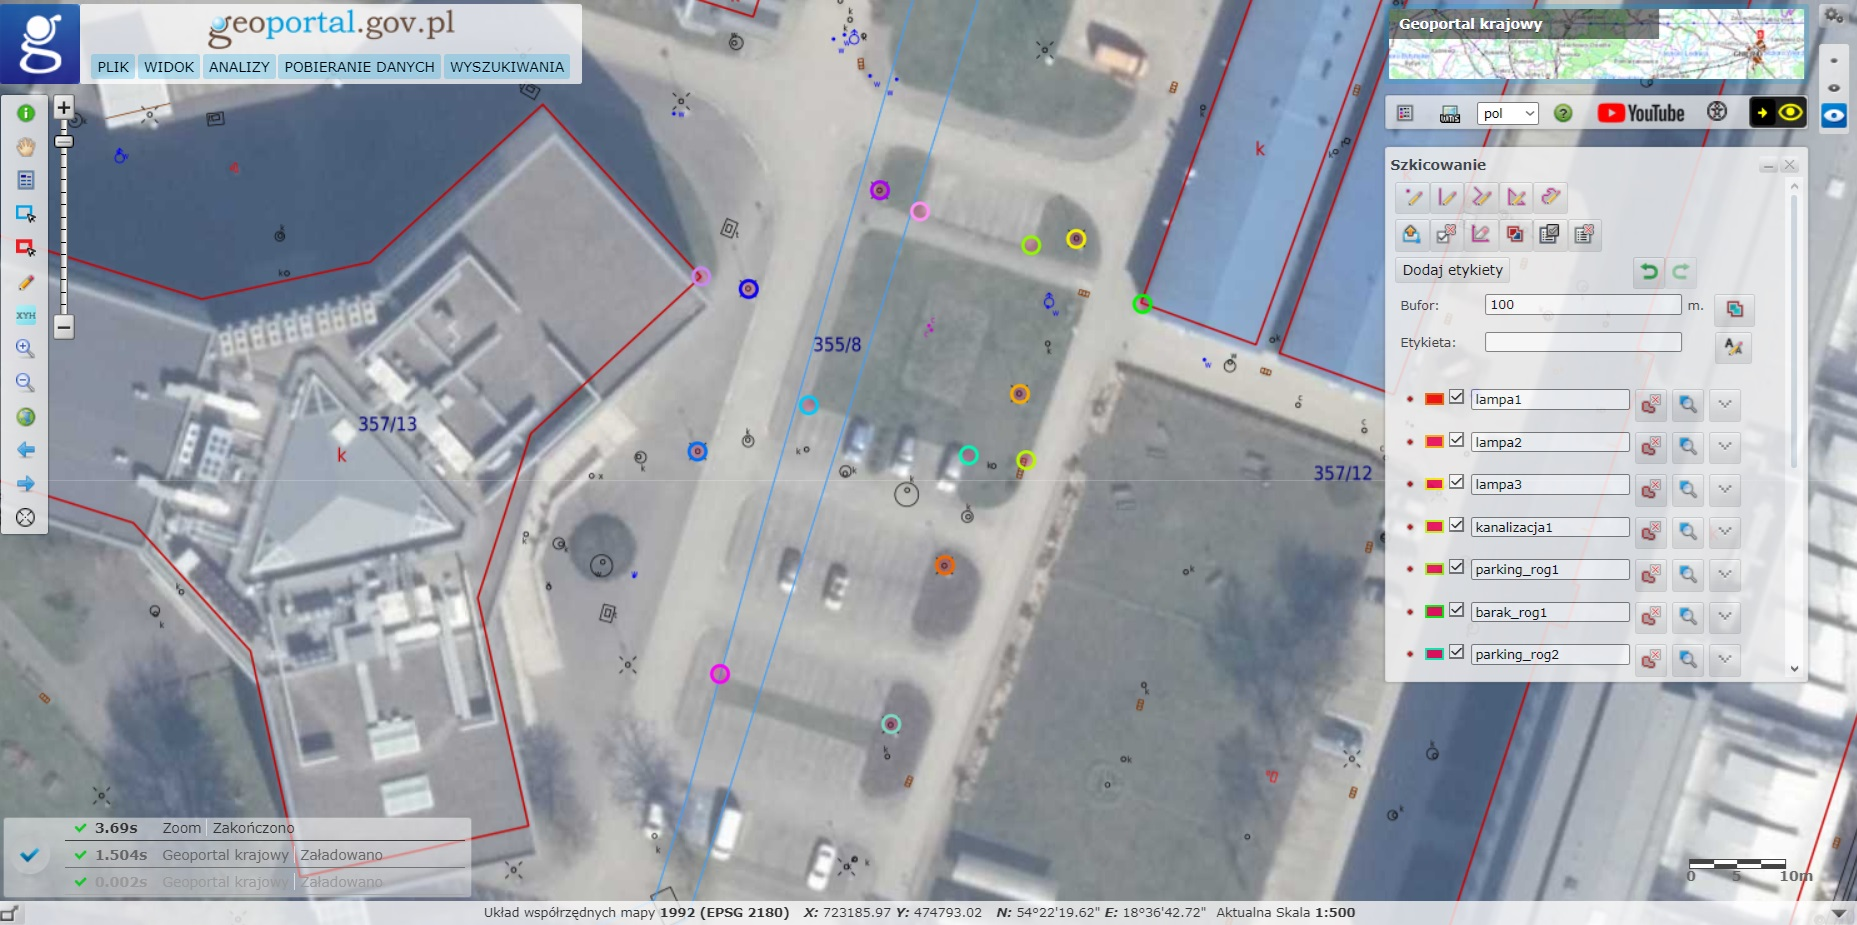

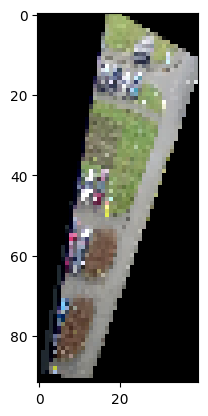

In [10]:
homography_weti1 = make_image_top_down(image_c_weti1, geo_points_weti1, img_points_weti1)

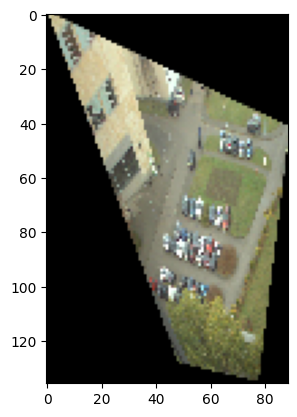

In [11]:
homography_weti2 = make_image_top_down(image_c_weti2, geo_points_weti2, img_points_weti2)

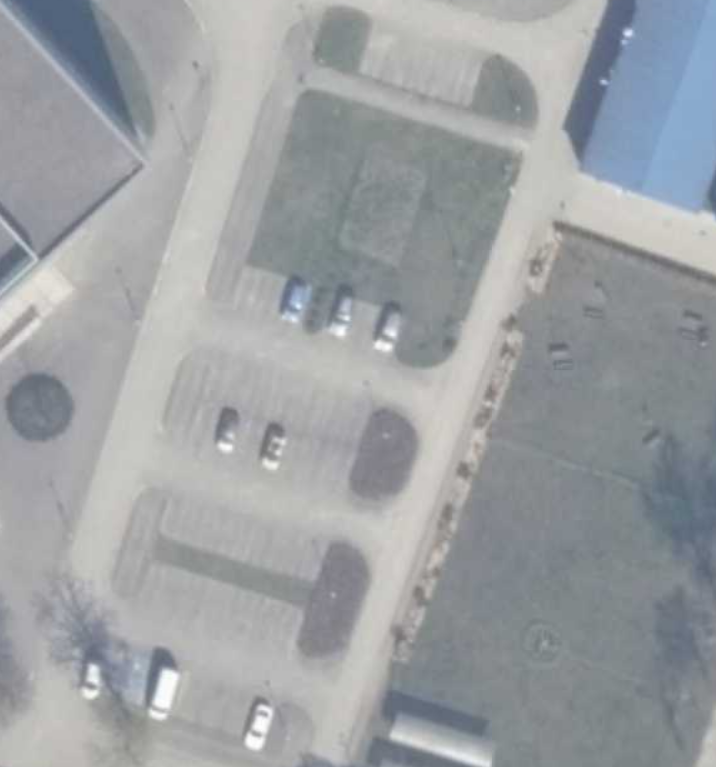

### HD

figsize=(8, 8)


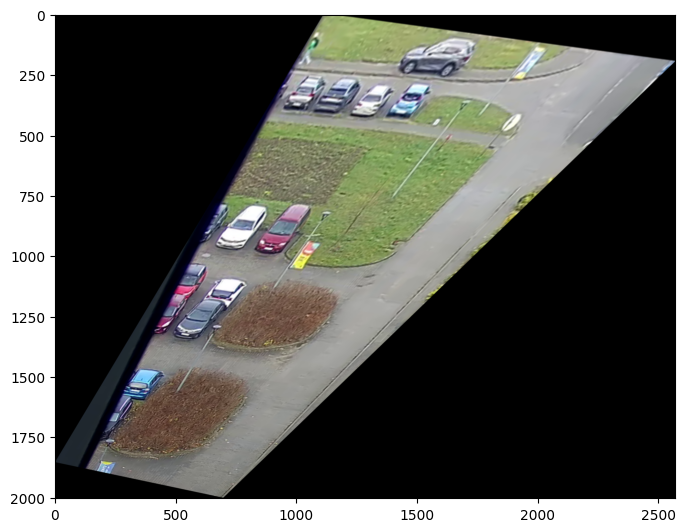

In [54]:
_ = make_image_top_down(image_c_weti1, geo_points_weti1, img_points_weti1, aa=True, figsize=(8, 8))

figsize=(8, 8)


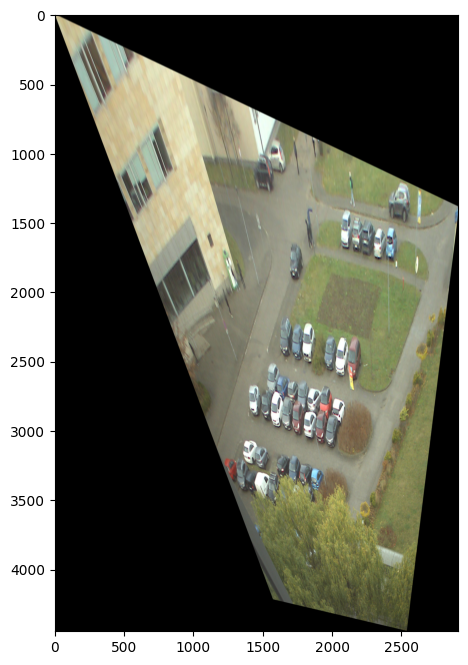

In [15]:
_ = make_image_top_down(image_c_weti2, geo_points_weti2, img_points_weti2, aa=True, figsize=(8, 8))

## Test punktów

In [17]:
print("weti1")
for k, img, geo in zip(keys_weti1, img_points_weti1, geo_points_weti1):
    transformed_point = np.dot(H1, np.array([*img[0], 1]))
    transformed_point /= transformed_point[2]
    print(k, img[0], geo, transformed_point)

print("weti2")
for k, img, geo in zip(keys_weti2, img_points_weti2, geo_points_weti2):
    transformed_point = np.dot(H2, np.array([*img[0], 1]))
    transformed_point /= transformed_point[2]
    print(k, img[0], geo, transformed_point)

weti1
lampa1 [180.68476132 307.56306128] [26.12765642 16.83414825] [26.20009695 17.22311563  1.        ]
lampa2 [243.82087859 160.32203159] [34.0651723 35.0242888] [34.36268505 35.69951919  1.        ]
lampa3 [264.40496475  65.46368951] [40.08445517 51.42848827] [40.06107055 51.40768214  1.        ]
kanalizacja1 [305.62965181 211.05723552] [34.72663195 28.01281644] [35.00526091 27.36404273  1.        ]
barak_rog1 [422.80198167  82.08924654] [47.02978156 44.54930785] [46.79416894 44.66514722  1.        ]
parking_rog1 [189.88585458  79.72896254] [35.32194564 50.70088265] [35.46321248 50.57560796  1.        ]
parking_rog2 [162.10190717 222.94715253] [28.64120312 28.4758382 ] [28.1103515 28.0906586  1.       ]
weti2
lampa1 [1012.28562     299.52988652] [26.12765642 16.83414825] [26.12352546 17.15337661  1.        ]
lampa2 [1237.98898749  153.39526404] [34.0651723 35.0242888] [34.15619354 35.62241289  1.        ]
lampa3 [1357.6062723    62.62819725] [40.08445517 51.42848827] [39.97443347 51

### Merging images - weti1 to weti2
probably negligible difference

In [23]:
common_keys = list(set(keys_weti1).intersection(keys_weti2))

common_points_weti1 = {}
for k, img, geo in zip(keys_weti1, img_points_weti1, geo_points_weti1):
    if k in common_keys:
        transformed_point = np.dot(H1, np.array([*img[0], 1]))
        transformed_point /= transformed_point[2]
        common_points_weti1[k] = transformed_point[:2]
        
common_points_weti2 = {}
for k, img, geo in zip(keys_weti2, img_points_weti2, geo_points_weti2):
    if k in common_keys:
        transformed_point = np.dot(H2, np.array([*img[0], 1]))
        transformed_point /= transformed_point[2]
        common_points_weti2[k] = transformed_point[:2]

# right order
common_points_weti1 = np.array([common_points_weti1[ck] for ck in common_keys], dtype=np.float32)
common_points_weti2 = np.array([common_points_weti2[ck] for ck in common_keys], dtype=np.float32)
print(f"weti1:\n{common_points_weti1=}")
print(f"weti2:\n{common_points_weti2=}")

weti1:
common_points_weti1=array([[28.110352, 28.090658],
       [26.200096, 17.223116],
       [34.362686, 35.69952 ],
       [35.00526 , 27.364042],
       [46.79417 , 44.665146],
       [40.06107 , 51.40768 ],
       [35.46321 , 50.575607]], dtype=float32)
weti2:
common_points_weti2=array([[28.400093, 28.320152],
       [26.123526, 17.153378],
       [34.156193, 35.622414],
       [35.175274, 26.796892],
       [47.334457, 44.074833],
       [39.974434, 51.502052],
       [35.285023, 51.070835]], dtype=float32)


In [27]:
H12, status12 = cv2.findHomography(common_points_weti1, common_points_weti2)

homography_info['cameras']['weti1_weti2'] = {'filename': 'H_wet1_weti2.npy'}

with open(os.path.join(info_path, 'info'), 'w') as json_file:
    json.dump(homography_info, json_file, indent=4)
    
np.save(os.path.join(info_path, homography_info['cameras']['weti1_weti2']['filename']), H12)

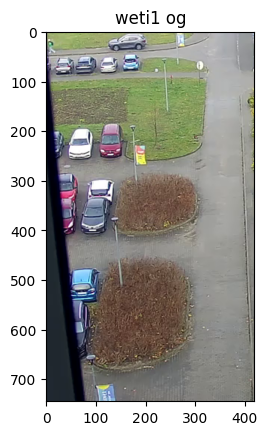

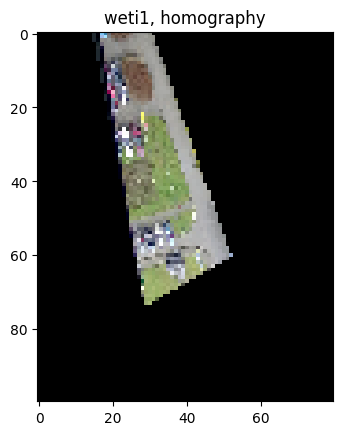

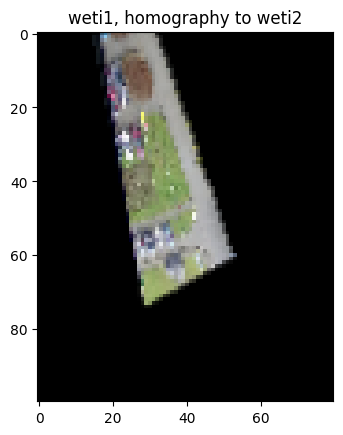

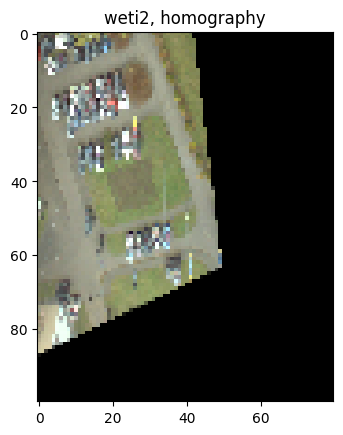

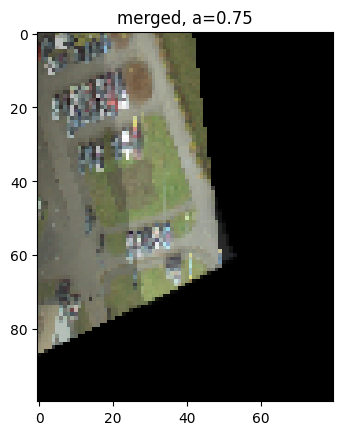

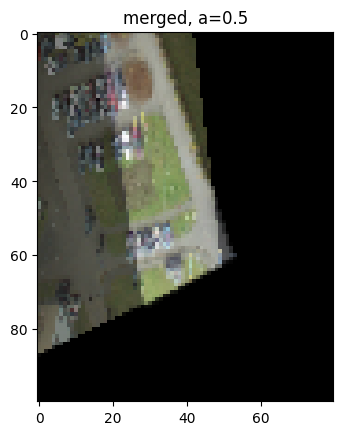

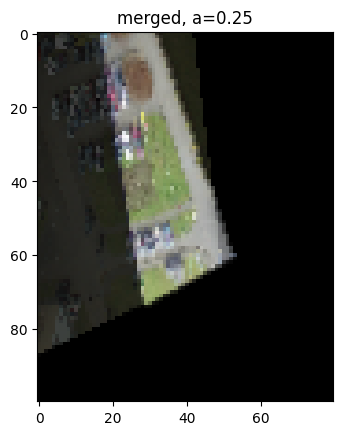

In [34]:
plt.imshow(image_c_weti1)
plt.title("weti1 og")
plt.show()

image_c_weti1_h = cv2.warpPerspective(image_c_weti1, H1, (80, 100))
plt.imshow(image_c_weti1_h)
plt.title("weti1, homography")
plt.show()

image_c_weti1_h2 = cv2.warpPerspective(image_c_weti1_h, H12, (80, 100))
plt.imshow(image_c_weti1_h2)
plt.title("weti1, homography to weti2")
plt.show()

image_c_weti2_h = cv2.warpPerspective(image_c_weti2, H2, (80, 100))
plt.imshow(image_c_weti2_h)
plt.title("weti2, homography")
plt.show()

for a in [0.75, 0.5, 0.25]:
    merged_image = cv2.addWeighted(image_c_weti2_h, a, image_c_weti1_h2, 1 - a, 0)
    plt.imshow(merged_image)
    plt.title(f"merged, {a=}")
    plt.show()